# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

tf.keras.utils.set_random_seed(0)


def show_loss_accuracy_evolution(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

17464789/17464789 [==============================] - 0s 0us/step
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178,

In [ ]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

1641221/1641221 [==============================] - 0s 0us/step


For transforming an id-sequence to a phrase use get_words

In [ ]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i, '<UNK>') for i in sentence])


get_words(train_data[0], int2word)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# MLP model

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model

In [ ]:
def vectorize_text_sentence(text, word2int):
    tokens = text.split(' ')
    tokens_id = [word2int.get(tk,2) for tk in tokens]
    return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_text_sentence(text, word2int))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`


In [ ]:
from collections import Counter


def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())


text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False))
print(
    'bag_of_words with indexes', {
        word2int[w.lower()]: p
        for w, p in get_bag_of_words(text_sequence, norm=False).items()
    })

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}
bag_of_words with indexes {308: 1, 1232: 2, 8: 1, 106: 1, 102: 2, 1083: 1, 99: 1}


After that, we convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

In [ ]:
def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words)
    bow = get_bag_of_words(sequence, norm)
    for w, freq in bow.items():
        if w < num_words:
            vec[w] = freq
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results


x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

## Define and train a model
Define, compile and fit your sequential model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=(10003, )))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1, activation='sigmoid'))

es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=50, batch_size=16, callbacks=[es_callback])

Epoch 1/50
1250/1250 [==============================] - 9s 5ms/step - loss: 0.6860 - accuracy: 0.6191 - val_loss: 0.6683 - val_accuracy: 0.6990
Epoch 2/50
1250/1250 [==============================] - 4s 4ms/step - loss: 0.6236 - accuracy: 0.7582 - val_loss: 0.5649 - val_accuracy: 0.8100
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5091 - accuracy: 0.8226 - val_loss: 0.4513 - val_accuracy: 0.8486
Epoch 4/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4194 - accuracy: 0.8516 - val_loss: 0.3787 - val_accuracy: 0.8706
Epoch 5/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3608 - accuracy: 0.8663 - val_loss: 0.3360 - val_accuracy: 0.8744
Epoch 6/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.3206 - accuracy: 0.8803 - val_loss: 0.3111 - val_accuracy: 0.8776
Epoch 7/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2911 - accuracy: 0.8913 - val_loss: 0.2925 - val_accuracy:

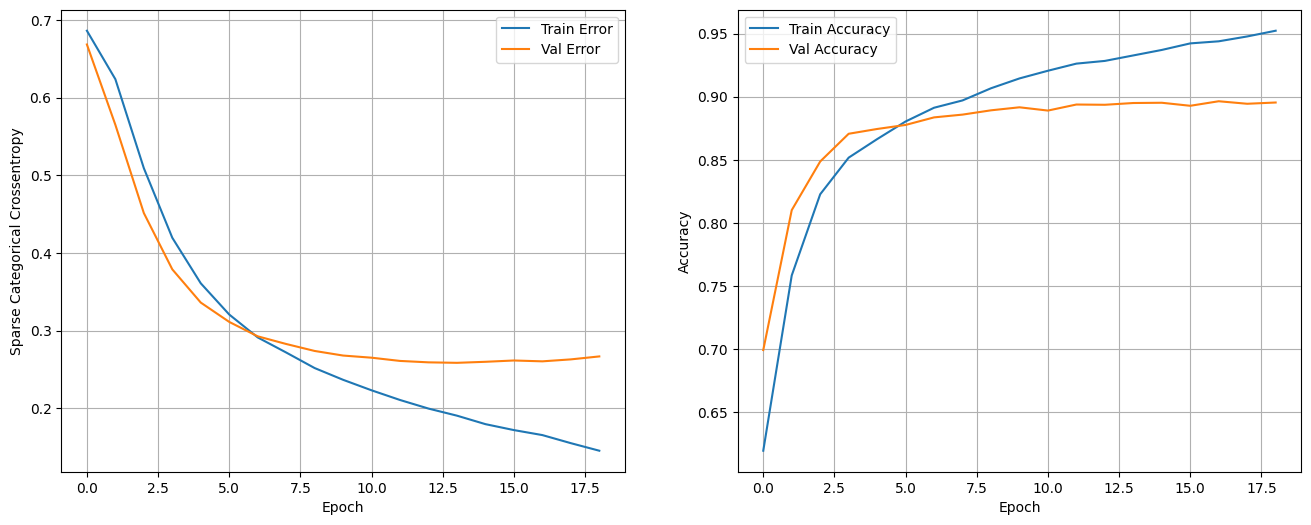

In [ ]:
show_loss_accuracy_evolution(history)

### Evaluate the model
You need to obtain a Test Accuracy > 0.85. Try to get more than 0.9!

In [ ]:
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 2s 3ms/step - loss: 0.2910 - accuracy: 0.8861
Test Loss: 0.2909849286079407
Test Accuracy: 0.8860800266265869


### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
           'the movie is not bad I like it']

sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

x_pred = vectorize_sequences(sequences, num_words=num_words)
np.round(model.predict(x_pred), 3)

1/1 [==============================] - 0s 113ms/step


array([[0.   ],
       [1.   ],
       [1.   ],
       [0.99 ],
       [0.   ],
       [0.002]], dtype=float32)

# RNN model

Lets use a recurrent neural network and compare results


### Simple RNN model

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In sequence classification we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

In [ ]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 2, return_sequences=False)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

input dim (batch, timesteps, feature):  (32, 10, 4)
return_state=False output shape:  (32, 2)


### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [ ]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features]
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)
# last lstm layer depends in [one to many or  many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)
output = layers.Dense(1, activation='sigmoid')(lstm_3)
model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
print(model.summary())
# inputs = tf.random.normal([32, timesteps, features])
# print(model(inputs).shape)

Model: "rnn_example"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 8)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            18688     
                                                                 
 lstm_2 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
Total params: 84736 (331.00 KB)
Trainable params: 84736 (331.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

[link to documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [ ]:
model = keras.Sequential()

# If you crete a second layer you must set return_sequences=True
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(timesteps, features))
)
# Second Bidirectional layer
model.add(layers.Bidirectional(layers.LSTM(32)))
# Output
model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 10, 128)           37376     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 79242 (309.54 KB)
Trainable params: 79242 (309.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Loading Data

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
'''size = 15000
(train_data, train_labels), (test_data, test_labels) = (
    (train_data[:size], train_labels[:size]), (test_data[:size], test_labels[:size]))
'''
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

print(train_data.shape, test_data.shape)

(25000,) (25000,)


#### Data Preprocessing

For data preprocessing we first use [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences):
```python
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
```
- **padding**:	'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.
- **truncating**:	String, 'pre' or 'post' (optional, defaults to 'pre'): remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.


Our RNN will take sequences of constant length. In our case this length is the `maxlen`

In [ ]:
from tensorflow.keras.preprocessing import sequence
input_seq = [1, 2, 3]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len)
print('input sequence with padding: ', pad_seq)

input_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len)
print('input sequence with padding: ', pad_seq)


input sequence:  [1, 2, 3]
input sequence with padding:  [[0 0 1 2 3]]
input sequence:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
input sequence with padding:  [[5 6 7 8 9]]


In [ ]:
input_seq = [1, 2, 3]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len, padding='post')
print('input sequence with padding: ', pad_seq)

input_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len, truncating='post')
print('input sequence with padding: ', pad_seq)


input sequence:  [1, 2, 3]
input sequence with padding:  [[1 2 3 0 0]]
input sequence:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
input sequence with padding:  [[1 2 3 4 5]]


In [ ]:
max_len = 100
x_train_seq = sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


### Create the RNN model

For the input of the first rnn layer we need a tensor of `(timesteps, features)` or `(batchsize, timesteps, features)`. We have a matrix of sentences of `(train_size, max_len)`. Every sentence is a  `max_len`, we need to convert it to a sentence of one-hot vectors of dim `(max_len, num_words)`.
For get the one-hot encoding of every sequence we are going to use:

```python
layers.Embedding(input_dim=num_words, output_dim=num_words,
  input_length=max_len, embeddings_initializer='identity', trainable=False)
```

This layer converts the input tensor `(batch_size, max_len)` to one-hot encoded sequences `(batch_size, max_len, num_words)`





In [ ]:
seq = np.array([[[0, 1, 2, 2, 0]]])
print(seq, seq.shape)
layers.Embedding(input_dim=3, output_dim=3,
                 input_length=5, embeddings_initializer='identity',
                 trainable=False)(seq)

[[[0 1 2 2 0]]] (1, 1, 5)


<tf.Tensor: shape=(1, 1, 5, 3), dtype=float32, numpy=
array([[[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]]], dtype=float32)>

### RNN model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` or `keras.layers.Bidirectional`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))
## complete the model with recurrent layers
model.add(layers.SimpleRNN(16, return_sequences=True))
model.add(layers.SimpleRNN(16, return_sequences=False))
## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## set the loss and see the results
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)


Epoch 1/5
88/88 [==============================] - 19s 190ms/step - loss: 0.6654 - accuracy: 0.5820 - val_loss: 0.5357 - val_accuracy: 0.7456
Epoch 2/5
88/88 [==============================] - 17s 190ms/step - loss: 0.4630 - accuracy: 0.7896 - val_loss: 0.4735 - val_accuracy: 0.7828
Epoch 3/5
88/88 [==============================] - 17s 192ms/step - loss: 0.3875 - accuracy: 0.8348 - val_loss: 0.4404 - val_accuracy: 0.8052
Epoch 4/5
88/88 [==============================] - 16s 187ms/step - loss: 0.3487 - accuracy: 0.8512 - val_loss: 0.4323 - val_accuracy: 0.8044
Epoch 5/5
88/88 [==============================] - 16s 188ms/step - loss: 0.3153 - accuracy: 0.8695 - val_loss: 0.4577 - val_accuracy: 0.7868


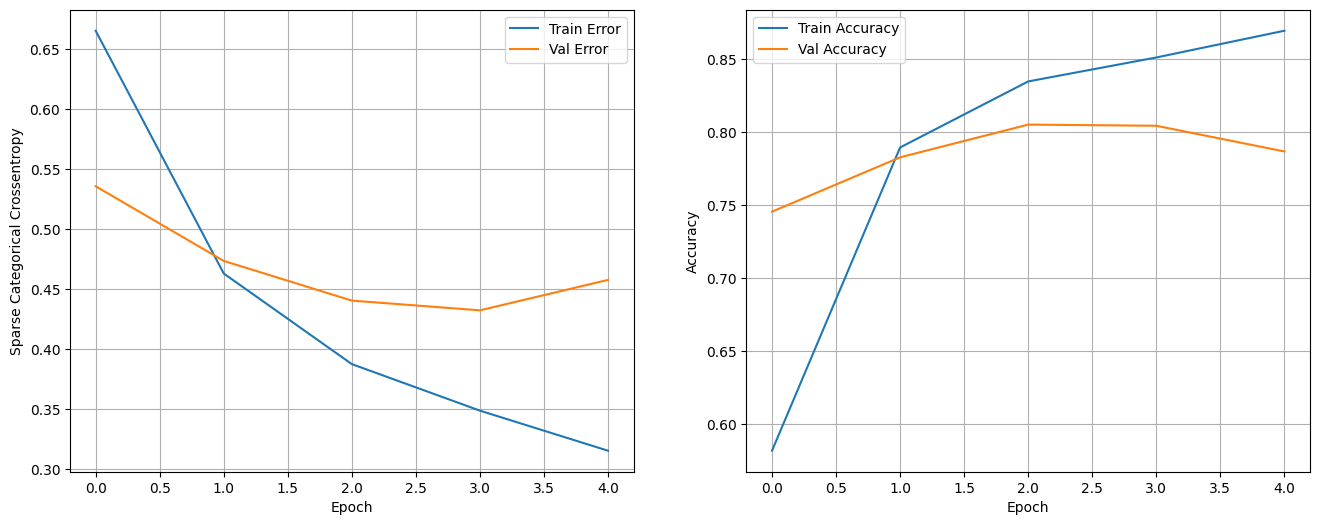

782/782 [==============================] - 16s 20ms/step - loss: 0.4715 - accuracy: 0.7808
Test Loss: 0.47147876024246216
Test Accuracy: 0.7807999849319458


In [ ]:
show_loss_accuracy_evolution(history)
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [ ]:
def show_errors(x_test, model, labels, int2word, n_samples=10):
    preds = 1.0 * (model.predict(x_test).flatten() > 0.5)
    bad_pred_inds = np.where(preds != labels)[0]
    n_samples = min(len(bad_pred_inds), n_samples)
    samples_inds = np.random.choice(bad_pred_inds, n_samples)
    for ind in samples_inds:
        print('Predicted : {0}, real : {1}, lenght: {2}'.format(
            int(preds[ind]), labels[ind], len(test_data[ind])))
        print(get_words(test_data[ind], int2word))
        print()
    return

show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 [==============================] - 15s 18ms/step
Predicted : 1, real : 0, lenght: 188
<START> the dog can act unfortunately nobody else in the cast of this <UNK> <UNK> <UNK> film can a <UNK> yet very clever dog <UNK> himself into the lives of two children much to the <UNK> of their <UNK> and cold <UNK> father in what can only be <UNK> as <UNK> the evil <UNK> <UNK> his children who may or may not be <UNK> <UNK> from playing with <UNK> neither the children nor <UNK> <UNK> soon the children are <UNK> and <UNK> has to help the police find them it's only then that the old man <UNK> that <UNK> is good not bad br br tom <UNK> whose only previous acting experience appears to have been playing the <UNK> <UNK> <UNK> on green <UNK> plays one of the <UNK> so does the <UNK> over <UNK> <UNK> previous screen <UNK> include <UNK> <UNK> <UNK> and the <UNK> it's a <UNK> world she also played both <UNK> and <UNK> in the past and here attempts to <UNK> her good girl <UNK> by playing it bad br br st

#### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
           'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 3)

1/1 [==============================] - 0s 34ms/step


array([[0.043],
       [0.95 ],
       [0.879],
       [0.461],
       [0.028],
       [0.045]], dtype=float32)

In [ ]:
1.0*(model.predict(x_pred) > 0.5)

1/1 [==============================] - 0s 32ms/step


array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.]])

### GRU model
Use `keras.layers.GRU`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.GRU(16, return_sequences=True))
model.add(layers.GRU(16, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 6s 27ms/step - loss: 0.6887 - accuracy: 0.5330 - val_loss: 0.6671 - val_accuracy: 0.6076
Epoch 2/5
88/88 [==============================] - 2s 19ms/step - loss: 0.4976 - accuracy: 0.7587 - val_loss: 0.4428 - val_accuracy: 0.8048
Epoch 3/5
88/88 [==============================] - 2s 20ms/step - loss: 0.4022 - accuracy: 0.8228 - val_loss: 0.4181 - val_accuracy: 0.8156
Epoch 4/5
88/88 [==============================] - 2s 20ms/step - loss: 0.3675 - accuracy: 0.8402 - val_loss: 0.4096 - val_accuracy: 0.8180
Epoch 5/5
88/88 [==============================] - 2s 19ms/step - loss: 0.3566 - accuracy: 0.8466 - val_loss: 0.4129 - val_accuracy: 0.8172


In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 4s 5ms/step - loss: 0.4235 - accuracy: 0.8081
Test Loss: 0.42353472113609314
Test Accuracy: 0.8081200122833252


### LSTM model
Use `keras.layers.LSTM`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.LSTM(16, return_sequences=True))
model.add(layers.LSTM(16, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 7s 28ms/step - loss: 0.6286 - accuracy: 0.6336 - val_loss: 0.4969 - val_accuracy: 0.7700
Epoch 2/5
88/88 [==============================] - 2s 19ms/step - loss: 0.4342 - accuracy: 0.8039 - val_loss: 0.4176 - val_accuracy: 0.8104
Epoch 3/5
88/88 [==============================] - 2s 19ms/step - loss: 0.3918 - accuracy: 0.8269 - val_loss: 0.4207 - val_accuracy: 0.8116
Epoch 4/5
88/88 [==============================] - 2s 19ms/step - loss: 0.3610 - accuracy: 0.8447 - val_loss: 0.4211 - val_accuracy: 0.8068
Epoch 5/5
88/88 [==============================] - 2s 20ms/step - loss: 0.3515 - accuracy: 0.8492 - val_loss: 0.4183 - val_accuracy: 0.8148


In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 4s 5ms/step - loss: 0.4257 - accuracy: 0.8038
Test Loss: 0.42573282122612
Test Accuracy: 0.8037999868392944


### Bidirectional model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` with `keras.layers.Bidirectional`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=True))

## complete the model with recurrent layers
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=False)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## set the loss and see the results
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

epochs = 50
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.15, epochs=epochs,
                    batch_size=128, callbacks=[es_callback])

Epoch 1/50
167/167 [==============================] - 32s 136ms/step - loss: 0.6910 - accuracy: 0.5647 - val_loss: 0.6878 - val_accuracy: 0.6125
Epoch 2/50
167/167 [==============================] - 10s 57ms/step - loss: 0.6697 - accuracy: 0.6498 - val_loss: 0.6281 - val_accuracy: 0.6739
Epoch 3/50
167/167 [==============================] - 8s 48ms/step - loss: 0.5095 - accuracy: 0.7601 - val_loss: 0.4563 - val_accuracy: 0.7915
Epoch 4/50
167/167 [==============================] - 7s 42ms/step - loss: 0.4048 - accuracy: 0.8233 - val_loss: 0.4300 - val_accuracy: 0.8080
Epoch 5/50
167/167 [==============================] - 9s 52ms/step - loss: 0.3777 - accuracy: 0.8374 - val_loss: 0.4233 - val_accuracy: 0.8139
Epoch 6/50
167/167 [==============================] - 8s 45ms/step - loss: 0.3608 - accuracy: 0.8474 - val_loss: 0.4226 - val_accuracy: 0.8133
Epoch 7/50
167/167 [==============================] - 8s 46ms/step - loss: 0.3501 - accuracy: 0.8528 - val_loss: 0.4408 - val_accuracy: 0.8

In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 7s 9ms/step - loss: 0.4338 - accuracy: 0.8046
Test Loss: 0.4337552785873413
Test Accuracy: 0.8045600056648254


#### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 3)

1/1 [==============================] - 1s 1s/step


array([[0.402],
       [0.956],
       [0.914],
       [0.857],
       [0.643],
       [0.646]], dtype=float32)

In [ ]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 [==============================] - 6s 8ms/step
Predicted : 1, real : 0, lenght: 168
<START> this was one of the <UNK> movies i have seen in some time i'm in my late <UNK> and watched it with my son in law early <UNK> and son <UNK> the scenery was beautiful but the story was a <UNK> we watched about an hour of it and turned it off i spent more time on my during the hour that we watched it than i spent actually watching the movie i gave it a 3 because i enjoyed the scenery and cinematography otherwise i would have given it a 1 i'm sure there are people who are really into the art of it all who will find my review <UNK> but we're all <UNK> to our own <UNK> right i couldn't figure out if this was supposed to be a <UNK> flick where the focus was on the mother or if it was supposed to be a movie for guys with the focus on battle and adventure in my opinion it didn't <UNK> in either

Predicted : 1, real : 0, lenght: 162
<START> <UNK> does the opposite here she keeps growing and growin

###  Use a convolutional network instead of a RNN

```python
tf.keras.layers.Conv1D(
    filters, kernel_size
)
```

```python
tf.keras.layers.MaxPool1D(
    pool_size=2
)
```

```python
tf.keras.layers.Flatten()
```

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3


In [ ]:
max_len = 100
x_train_seq = sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))


model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 5s 20ms/step - loss: 0.6925 - accuracy: 0.5109 - val_loss: 0.6895 - val_accuracy: 0.4964
Epoch 2/5
88/88 [==============================] - 1s 16ms/step - loss: 0.5576 - accuracy: 0.7110 - val_loss: 0.4551 - val_accuracy: 0.7904
Epoch 3/5
88/88 [==============================] - 1s 16ms/step - loss: 0.4048 - accuracy: 0.8163 - val_loss: 0.4104 - val_accuracy: 0.8116
Epoch 4/5
88/88 [==============================] - 1s 16ms/step - loss: 0.3513 - accuracy: 0.8473 - val_loss: 0.4051 - val_accuracy: 0.8156
Epoch 5/5
88/88 [==============================] - 1s 17ms/step - loss: 0.3185 - accuracy: 0.8641 - val_loss: 0.4145 - val_accuracy: 0.8124


In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 3)

1/1 [==============================] - 0s 136ms/step


array([[0.208],
       [0.925],
       [0.844],
       [0.658],
       [0.416]], dtype=float32)

In [ ]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 [==============================] - 2s 2ms/step
Predicted : 1, real : 0, lenght: 931
<START> is a b movie no doubt about it br br of course if you take a look at the cast <UNK> you might have some high hopes for its entertainment potential this film is <UNK> with all of those wonderful character actors that you <UNK> up with the ones with the faces you immediately <UNK> even though you probably don't know their names it's amazing that the filmmakers were able to get all of these people together on one project almost like they decided to do a b movie actor <UNK> the cast even includes a couple of really first rate actors david <UNK> who most people will <UNK> from <UNK> although my favorite of his roles is jack the <UNK> in <UNK> after <UNK> and <UNK> <UNK> who many will remember as <UNK> in <UNK> these two actors have done some excellent work in their long <UNK> and made some very fine films br br however as impressive as this collection of actors is their talent is never fully 